<a href="https://colab.research.google.com/github/steliosg23/TextAnalytics-DS-2025/blob/main/TA_Assignment_1_N_grams_v2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 (Exercice 3)

## (i)
Implement a bigram and a trigram language model
for sentences, using Laplace smoothing or optionally Kneser-
Ney smoothing, which is much better.

In practice, n-gram language models
compute the sum of the logarithms of the n-gram probabilities of each sequence, instead of
their product (why?) and you should do the same.

Assume that each sentence starts with the
pseudo-token *start* (or two pseudo-tokens *start1*, *start2* for the trigram model) and
ends with the pseudo-token *end*. Train your models on a training subset of a corpus (e.g., a
subset of a corpus included in NLTK).

Include in the vocabulary
only words that occur, e.g., at least 10 times in the training subset. Use the same vocabulary
in the bigram and trigram models. Replace all out-of-vocabulary (OOV) words (in the
training, development, test subsets) by a special token *UNK*.

Alternatively, you may want
to use BPEs instead of words to avoid unknown words.

In [ ]:
import nltk, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, math, string, re
from nltk.corpus import reuters
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from nltk.metrics import edit_distance

In [ ]:
# Download necessary NLTK resources
nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Split the dataset into training, development, and test sets
data = reuters.sents()

# First, split the data into a train set and a test set (80-20 split)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# Then, split the temp_data into dev and test sets (50-50 split, making 10% dev, 10% test)
dev_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
# Function to preprocess the text
def preprocess_corpus(corpus, n, min_freq):
    ngrams = defaultdict(int)
    word_freq = defaultdict(int)
    sentences = []

    for sentence in corpus:

        sentence = [token.lower() for token in sentence]

        # Add start and end tokens for bigram/trigram models
        if n == 2:
            sentence = ['*start*'] + sentence + ['*end*']
        elif n == 3:
            sentence = ['*start1*', '*start2*'] + sentence + ['*end*']

        sentences.append(sentence)

        # Count word frequencies and n-grams
        for i in range(len(sentence)):
            word_freq[sentence[i]] += 1
            if i < len(sentence) - (n - 1):
                ngram = tuple(sentence[i:i + n])
                ngrams[ngram] += 1

    # Filter out OOV words: only keep words that occur at least `min_freq` times
    vocab = {word for word, count in word_freq.items() if count >= min_freq}
    vocab.add('*unk*')  # Add the UNK token to the vocabulary

    return sentences, ngrams, word_freq, vocab

In [ ]:
# Function to estimate probabilities using Laplace smoothing
def estimate_probabilities(ngrams, word_freq, vocab_size, n):
    probabilities = defaultdict(float)

    # Total number of n-grams for smoothing
    for ngram, count in ngrams.items():
        context = ngram[:-1]  # The previous (n-1) words
        probabilities[ngram] = (count + 1) / (word_freq[context] + vocab_size)

    return probabilities

### Why do n-gram language models compute the sum of the logarithms of the n-gram probabilities instead of their product?

N-gram language models use the **sum of logarithms** instead of the product of probabilities for **numerical stability** and practical reasons:

#### **Avoiding Numerical Underflow:**
   - Probabilities in language models are often very small (e.g., $ 10^{-6} $).
   - Multiplying many small numbers results in values too small for the computer to handle, leading to **numerical underflow**.
   
#### **Logarithms Prevent Problems with Zero Probabilities:**
   - Directly multiplying probabilities of unseen events (zero probability) results in invalid calculations.
   - **Logarithms** of small probabilities can be computed even for unseen n-grams (using smoothing), and avoid the issue of $log(0)$.

#### **Easier to Optimize:**
   - **Log probabilities** are additive, making them easier to work with when optimizing models.
   - The sum of log-probabilities is more **intuitive** for comparing the likelihood of different sequences.

#### **Computational Efficiency:**
   - Adding logs is computationally more efficient than multiplying very small numbers plus it's simpler and more stable, especially for large datasets.


In [ ]:
# Function to compute the log probability of a sentence
def compute_log_prob(sentence, model, vocab, n):
    log_prob = 0.0

    # Add start and end tokens for the sentence
    if n == 2:
        sentence = ['*start*'] + sentence + ['*end*']
    elif n == 3:
        sentence = ['*start1*', '*start2*'] + sentence + ['*end*']

    # Calculate the log probability using the model
    for i in range(len(sentence) - n + 1):
        ngram = tuple(sentence[i:i + n])
        prob = model.get(ngram, 1 / (len(vocab) ** n))  # Default to UNK probability
        log_prob += math.log(prob)

    return log_prob

In [ ]:
min_freq = 10
n_values = [2, 3]  # Bigram and Trigram



for n in n_values:

    # Preprocess the Reuters corpus for the current n-gram model (using the training set only)
    train_sentences, ngrams, word_freq, vocab = preprocess_corpus(train_data, n, min_freq)

    # Estimate probabilities using Laplace smoothing
    vocab_size = len(vocab)
    ngram_model = estimate_probabilities(ngrams, word_freq, vocab_size, n)

    # Randomly select 10 sentences from the training subset to compute log probabilities
    random_sentences = random.sample(train_sentences, 10)

    # Compute the log probability for 10 random sentences from the training corpus
    print(f"\nTraining {n}-gram model...")
    for i, sentence in enumerate(random_sentences):
        log_prob = compute_log_prob(sentence, ngram_model, vocab, n)
        print(f"Sentence {i + 1}: {sentence}")
        print(f"Log probability of sentence {i + 1} in training set: {log_prob}")
        print()

    # Evaluate on the development set
    # dev_sentences, _, _, _ = preprocess_corpus(dev_data, n, min_freq)
    # print(f"\nEvaluating {n}-gram model on development set...")
    # for i, sentence in enumerate(random.sample(dev_sentences, 10)):
    #     log_prob = compute_log_prob(sentence, ngram_model, vocab, n)
    #     print(f"Sentence {i + 1}: {sentence}")
    #     print(f"Log probability of sentence {i + 1} in development set: {log_prob}")
    #     print()

    # Evaluate on the test set
    # test_sentences, _, _, _ = preprocess_corpus(test_data, n, min_freq)
    # print(f"\nEvaluating {n}-gram model on test set...")
    # for i, sentence in enumerate(random.sample(test_sentences, 10)):
    #     log_prob = compute_log_prob(sentence, ngram_model, vocab, n)
    #     print(f"Sentence {i + 1}: {sentence}")
    #     print(f"Log probability of sentence {i + 1} in test set: {log_prob}")
    #     print()


Training 2-gram model...
Sentence 1: ['*start*', 'the', 'company', 'is', 'also', 'marketing', 'an', 'extended', 'line', 'of', '"', 'laser', 'tag', '"', 'kits', ',', 'which', 'shoot', 'rays', 'of', 'light', 'and', 'tell', 'you', 'when', 'you', "'", 've', 'hit', 'someone', '.', '*end*']
Log probability of sentence 1 in training set: -232.21714867088494

Sentence 2: ['*start*', 'intervention', 'board', 'details', 'ec', 'sugar', 'sales', 'a', 'total', '59', ',', '000', 'tonnes', 'of', 'current', 'series', 'white', 'sugar', 'received', 'export', 'rebates', 'of', 'a', 'maximum', '45', '.', '678', 'european', 'currency', 'units', '(', 'ecus', ')', 'per', '100', 'kilos', 'at', 'today', "'", 's', 'european', 'community', '(', 'ec', ')', 'tender', ',', 'the', 'u', '.', 'k', '.', '*end*']
Log probability of sentence 2 in training set: -294.0426388698978

Sentence 3: ['*start*', 'such', 'a', 'merger', 'would', 'be', 'complex', 'and', 'analysts', 'said', 'it', 'would', 'result', 'in', 'an', 'airli

## (ii)

Estimate the cross-entropy and perplexity of your two models on a test subset of the
corpus, treating the entire test subset as a single sequence of sentences, with *start* (or
*start1*, *start2*) at the beginning of each sentence, and *end* at the end of each sentence.

Do not include probabilities of the form P(*start*|…) or P(*start1*|…), P(*start2*|…) in the
computation of cross-entropy and perplexity, since we are not predicting the start pseudo-
tokens; but include probabilities of the form P(*end*|…), since we do want to be able to
predict if a word will be the last one of a sentence.

You must also count *end* tokens (but not
*start*, *start1*, *start2* tokens) in the total length N of the test corpus.

In [ ]:
# Function to compute log probabilities for the entire development subset
def compute_log_probabilities(sentences, model, vocab, n):
    """
    Compute the log probabilities for the entire development subset.

    Parameters:
    - sentences: List of tokenized sentences (from the development set)
    - model: The n-gram model (probability estimates)
    - vocab: Vocabulary of words
    - n: The order of the n-gram model (2 for bigram, 3 for trigram)

    Returns:
    - log_prob_sum: The sum of log probabilities for all tokens in the development set
    - total_tokens: Total number of tokens (excluding start tokens, but including end tokens)
    """
    log_prob_sum = 0.0
    total_tokens = 0

    for sentence in sentences:
        # Add start and end tokens
        if n == 2:
            sentence = ['*start*'] + sentence + ['*end*']
        elif n == 3:
            sentence = ['*start1*', '*start2*'] + sentence + ['*end*']

        for i in range(1, len(sentence) - (n - 1)):  # Skip start tokens
            ngram = tuple(sentence[i:i + n])  # Current n-gram
            # Estimate the probability using Laplace smoothing
            prob = model.get(ngram, 1 / (len(vocab) ** n))  # Smooth unseen n-grams
            log_prob_sum += math.log(prob)
            total_tokens += 1

    return log_prob_sum, total_tokens

In [ ]:
# Function to compute cross-entropy and perplexity from log probabilities
def compute_cross_entropy_and_perplexity(log_prob_sum, total_tokens):
    cross_entropy = -log_prob_sum / total_tokens
    perplexity = 2 ** cross_entropy
    return cross_entropy, perplexity

# Function to evaluate log probabilities for the n-gram model
def evaluate_ngram_models_on_dev(n_values=[2, 3], min_freq=10):


    for n in n_values:
        # Preprocess the Reuters corpus for the current n-gram model (using the training set only)
        train_sentences, ngrams, word_freq, vocab = preprocess_corpus(train_data, n, min_freq)

        # Estimate probabilities using Laplace smoothing
        vocab_size = len(vocab)
        ngram_model = estimate_probabilities(ngrams, word_freq, vocab_size, n)

        # Preprocess development set sentences
        dev_sentences, _, _, _ = preprocess_corpus(dev_data, n, min_freq)

        # Compute log probabilities for the development subset
        log_prob_sum, total_tokens = compute_log_probabilities(dev_sentences, ngram_model, vocab, n)

        # Compute cross-entropy and perplexity
        cross_entropy, perplexity = compute_cross_entropy_and_perplexity(log_prob_sum, total_tokens)

        print(f"\nEvaluating {n}-gram model on development set...")
        print(f"Log probability sum for {n}-gram model: {log_prob_sum}")
        print(f"Cross-entropy for {n}-gram model: {cross_entropy}")
        print(f"Perplexity for {n}-gram model: {perplexity}")

In [ ]:
evaluate_ngram_models_on_dev()


Evaluating 2-gram model on development set...
Log probability sum for 2-gram model: -1243677.2647457323
Cross-entropy for 2-gram model: 6.8489333748876975
Perplexity for 2-gram model: 115.27480179098079

Evaluating 3-gram model on development set...
Log probability sum for 3-gram model: -2802978.4294866496
Cross-entropy for 3-gram model: 14.984461744618807
Perplexity for 3-gram model: 32416.97260618198


### Inference on Cross-Entropy and Perplexity of Bigram and Trigram Models

### **Cross-Entropy and Perplexity**
- **2-gram Model:**
  - Cross-entropy: 6.84
  - Perplexity: 115.27

- **3-gram Model:**
  - Cross-entropy: 14.98
  - Perplexity: 32,416


### **General Interpretation of Cross-Entropy and Perplexity**:
- **Cross-entropy** measures the average number of bits required to encode the development set. Lower values are better.
- **Perplexity** is a measure of how well the model predicts the next word in a sequence. Lower perplexity values indicate better prediction quality.

### **Comparing the Models**:
- The **bigram model** has **lower cross-entropy** and **lower perplexity** compared to the trigram model's cross-entropy and perplexity. This suggests that the bigram model is better at predicting the next word than the trigram model, at least in this particular evaluation on the development set.

### **Reasons for the Performance Difference**:
  - **Data Sparsity**: The trigram model uses more context (two previous words) to predict the next word, but it may suffer from data sparsity. With fewer observed trigrams in the training data, the model is less accurate, leading to higher cross-entropy and perplexity.
  - **Contextual Information**: The bigram model, with only one previous word as context, might generalize better to unseen sequences because it has less risk of overfitting and fewer sparse data issues.

### **Conclusion**:
The **bigram model** is more efficient in terms of predictive accuracy on the development set, as indicated by its lower cross-entropy and perplexity. The **trigram model**, while capturing more context, seems to be less effective in this scenario, likely due to issues like data sparsity or overfitting.


### Additive -a Smoothing

In [ ]:
# Function to estimate probabilities using additive smoothing
def estimate_probabilities(ngrams, word_freq, vocab_size, n, alpha):
    probabilities = defaultdict(float)

    # Total number of n-grams for smoothing
    for ngram, count in ngrams.items():
        context = ngram[:-1]  # The previous (n-1) words
        probabilities[ngram] = (count + alpha) / (word_freq[context] + alpha * vocab_size)

    return probabilities


def evaluate_ngram_models_on_dev_add_a(n_values=[2, 3], min_freq=10, alpha_list=np.linspace(0.001, 0.1, 100)):
    # Split the corpus into training, development, and test sets

    best_alpha_perplexity = {}
    best_alpha_entropy = {}

    for n in n_values:
        # Preprocess the Reuters corpus for the current n-gram model (using the training set only)
        train_sentences, ngrams, word_freq, vocab = preprocess_corpus(train_data, n, min_freq)

        vocab_size = len(vocab)

        perplexities = []
        entropies = []

        for alpha in alpha_list:
            # Estimate probabilities using additive smoothing
            ngram_model = estimate_probabilities(ngrams, word_freq, vocab_size, n, alpha)

            # Preprocess development set sentences
            dev_sentences, _, _, _ = preprocess_corpus(dev_data, n, min_freq)

            # Compute log probabilities for the development subset
            log_prob_sum, total_tokens = compute_log_probabilities(dev_sentences, ngram_model, vocab, n)

            # Compute cross-entropy and perplexity
            cross_entropy, perplexity = compute_cross_entropy_and_perplexity(log_prob_sum, total_tokens)
            perplexities.append(perplexity)
            entropies.append(cross_entropy)

        # Get best alpha values for perplexity and entropy
        best_alpha_perplexity[n] = alpha_list[np.argmin(perplexities)]
        best_alpha_entropy[n] = alpha_list[np.argmin(entropies)]

        # Create a figure with 2 subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot perplexity for different alpha values in the first subplot
        axes[0].plot(alpha_list, perplexities, label=f'{n}-gram Perplexity')
        best_alpha_p = best_alpha_perplexity[n]
        best_perplexity = min(perplexities)
        axes[0].scatter(best_alpha_p, best_perplexity, color='red')  # Mark the best alpha for perplexity
        axes[0].annotate(f'Alpha = {best_alpha_p}\nPerplexity = {best_perplexity:.2f}',
                         (best_alpha_p, best_perplexity), textcoords="offset points", xytext=(0, 10), ha='center')
        axes[0].set_xlabel('Alpha')
        axes[0].set_ylabel('Perplexity')
        axes[0].set_title(f'{n}-gram Perplexity vs. Alpha')
        axes[0].grid(True)
        axes[0].legend()

        # Plot entropy for different alpha values in the second subplot
        axes[1].plot(alpha_list, entropies, label=f'{n}-gram Entropy')
        best_alpha_e = best_alpha_entropy[n]
        best_entropy = min(entropies)
        axes[1].scatter(best_alpha_e, best_entropy, color='red')  # Mark the best alpha for entropy
        axes[1].annotate(f'Alpha = {best_alpha_e}\nEntropy = {best_entropy:.2f}',
                         (best_alpha_e, best_entropy), textcoords="offset points", xytext=(0, 10), ha='center')
        axes[1].set_xlabel('Alpha')
        axes[1].set_ylabel('Entropy')
        axes[1].set_title(f'{n}-gram Entropy vs. Alpha')
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        print(f"Best alpha for minimum perplexity:{best_perplexity}/ entropy: {best_entropy} in {n}-gram model: {best_alpha_perplexity[n]}")


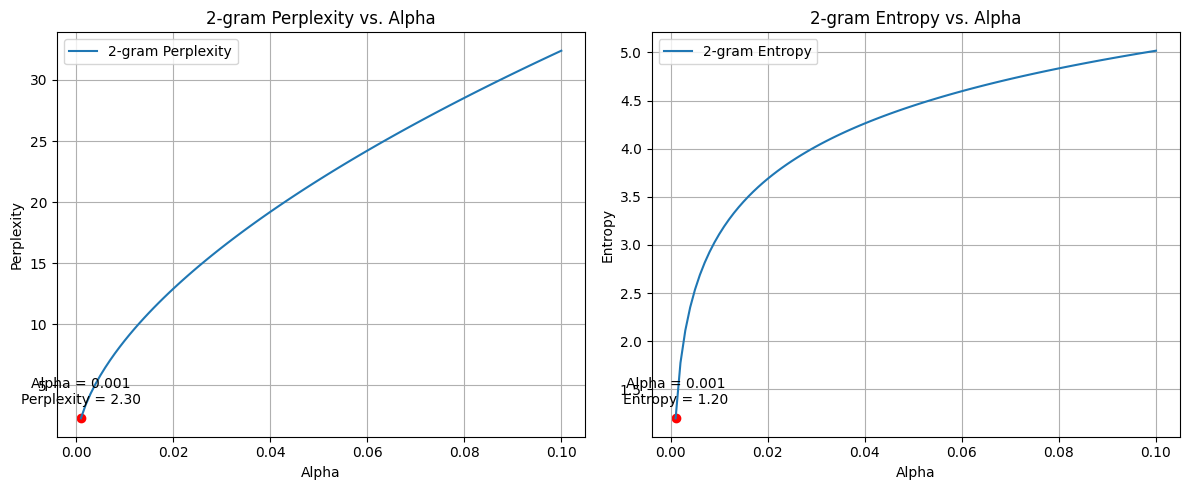

Best alpha for minimum perplexity:2.2960196326128886/ entropy: 1.1991349781425897 in 2-gram model: 0.001


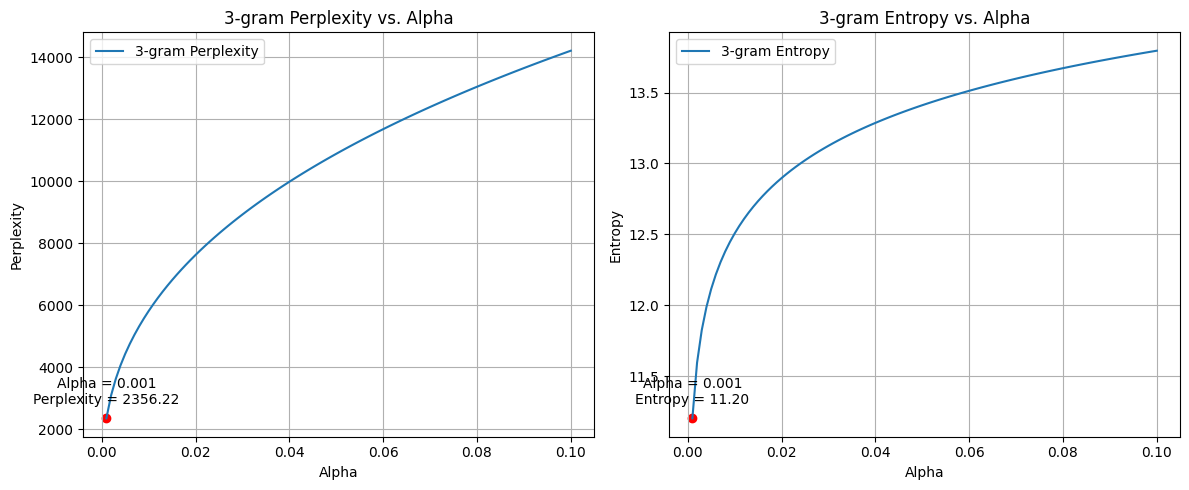

Best alpha for minimum perplexity:2356.2196609980056/ entropy: 11.202258326827149 in 3-gram model: 0.001


In [ ]:
evaluate_ngram_models_on_dev_add_a()

##(iii)
Write some code to show how your bigram and trigram language models can auto-
complete an incomplete sentence. For example, given “I would like to commend the”, generate completions like “rapporteur on his work *end*” or “president of the
Commission on his intervention *end*”.

You can simply use the most probable next word
(according to your language model) at each time-step.

If you are keen, you may also want to
use beam search, or methods like top-K or nucleus sampling, to improve the diversity of the
texts you generate.

Confirm (showing some examples of generated texts) that your trigram
model generates more fluent texts than your bigram model.

In [ ]:
train_sentences = train_data

# Flatten the list of sentences to get a list of all words in the corpus
words = [word.lower() for sentence in train_sentences for word in sentence]

# Count the frequency of each word
word_counts = Counter(words)

# Define the minimum frequency threshold for the vocabulary
min_freq = 10

# Create a vocabulary with words that appear at least `min_freq` times
vocab = {word for word, count in word_counts.items() if count >= min_freq}

# Replace words not in the vocabulary with <UNK>
processed_train_sentences = []
for sentence in train_sentences:
    processed_sentence = []
    for word in sentence:
        word = word.lower()
        if word in vocab:
            processed_sentence.append(word)
        else:
            processed_sentence.append('<UNK>')
    processed_train_sentences.append(processed_sentence)


In [ ]:
# Manually create bigrams and trigrams
def generate_bigrams(sentences):
    bigrams = []
    for sentence in sentences:
        sentence = ['<start>'] + sentence + ['<end>']
        for i in range(len(sentence) - 1):
            bigrams.append((sentence[i], sentence[i + 1]))
    return bigrams

def generate_trigrams(sentences):
    trigrams = []
    for sentence in sentences:
        sentence = ['<start1>', '<start2>'] + sentence + ['<end>']
        for i in range(len(sentence) - 2):
            trigrams.append((sentence[i], sentence[i + 1], sentence[i + 2]))
    return trigrams


In [ ]:
# Generate bigrams and trigrams
bigrams_list = generate_bigrams(processed_train_sentences)
trigrams_list = generate_trigrams(processed_train_sentences)

# Count bigrams and trigrams
bigram_counts = Counter(bigrams_list)
trigram_counts = Counter(trigrams_list)

# Count unigrams (including <start> and <end>)
unigram_counts = Counter(word for sentence in processed_train_sentences for word in ['<start>'] + sentence + ['<end>'])


In [ ]:
# Vocabulary size (including <UNK>)
V = len(vocab) + 1  # +1 for the <UNK> token

# Laplace-smoothed bigram probability
def bigram_prob(w1, w2, a=0.001):
    return (bigram_counts[(w1, w2)] + a) / (unigram_counts[w1] + a*V)

# Laplace-smoothed trigram probability
def trigram_prob(w1, w2, w3, a=0.001):
    return (trigram_counts[(w1, w2, w3)] +a) / (unigram_counts[w1] + a*V)

In [ ]:
# Compute log-probability for a sentence using bigram model
def bigram_log_prob(sentence):
    log_prob = 0.0
    sentence = ['<start>'] + sentence + ['<end>']
    for w1, w2 in generate_bigrams([sentence]):
        log_prob += np.log(bigram_prob(w1, w2))
    return log_prob


In [ ]:
# Compute log-probability for a sentence using trigram model
def trigram_log_prob(sentence):
    log_prob = 0.0
    sentence = ['<start1>', '<start2>'] + sentence + ['<end>']
    for w1, w2, w3 in generate_trigrams([sentence]):
        log_prob += np.log(trigram_prob(w1, w2, w3))
    return log_prob


In [ ]:
train_bigram_log_prob = sum(bigram_log_prob(sentence) for sentence in processed_train_sentences)

train_trigram_log_prob = sum(trigram_log_prob(sentence) for sentence in processed_train_sentences)


In [ ]:
# Generate the next word based on the bigram model
def bigram_autocomplete(start_sentence, max_length=20):
    sentence = start_sentence.split()  # Tokenize the input sentence into words
    sentence = [word.lower() for word in sentence]  # Lowercase for consistency

    # Keep adding the most probable next word until we reach <end> or max_length
    while len(sentence) < max_length:
        # Get the last word in the sentence
        last_word = sentence[-1]

        # Find the next word based on bigram probabilities
        next_word = predict_next_word_bi(last_word)

        # If we encounter the <end> token, we stop
        if next_word == '<end>':
            sentence.append(next_word)
            break

        sentence.append(next_word)

    return ' '.join(sentence)

# Predict next word based on the bigram model (highest probability)
def predict_next_word_bi(last_word):
    # We iterate through the vocabulary to find the word with the highest probability
    next_word_probabilities = {}

    # We generate all possible next words based on bigrams
    for word in vocab:
        next_word_probabilities[word] = bigram_prob(last_word, word)

    # Sort the next words by probability (highest first)
    sorted_next_words = sorted(next_word_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Return the word with the highest probability
    return sorted_next_words[0][0]


In [ ]:
# Generate the next word based on the trigram model
def trigram_autocomplete(start_sentence, max_length=20):
    sentence = start_sentence.split()  # Tokenize the input sentence into words
    sentence = [word.lower() for word in sentence]  # Lowercase for consistency


    # Keep adding the most probable next word until we reach <end> or max_length
    while len(sentence) < max_length:
        # Get the last two words in the sentence
        last_two_words = tuple(sentence[-2:])

        # Find the next word based on trigram probabilities
        next_word = predict_next_word_tri(last_two_words)

        # If we encounter the <end> token, we stop
        if next_word == '<end>':
            sentence.append(next_word)
            break

        sentence.append(next_word)

    return ' '.join(sentence)

# Predict next word based on the trigram model (highest probability)
def predict_next_word_tri(last_two_words):
    # We iterate through the vocabulary to find the word with the highest probability
    next_word_probabilities = {}

    # We generate all possible next words based on trigrams
    for word in vocab:
        next_word_probabilities[word] = trigram_prob(last_two_words[0], last_two_words[1], word)

    # Sort the next words by probability (highest first)
    sorted_next_words = sorted(next_word_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Return the word with the highest probability
    return sorted_next_words[0][0]


In [ ]:
bigram_sentences = [
    "The company has been",
    "He is planning to",
    "I would like to",
    "She went to the",
    "This is a very",
]

trigram_sentences = [
    "The company has been very",
    "We are looking forward to",
    "He is planning to visit",
    "The government is trying to",
    "I haven't seen the report"
]

In [ ]:
# Generate bigram completions
print("Bigram Model Completions:")
for sentence in bigram_sentences:
    completion = bigram_autocomplete(sentence, max_length=20)
    print(f"Input: '{sentence}'\nCompleted: '{completion}'\n")

Bigram Model Completions:
Input: 'The company has been'
Completed: 'the company has been a share , 000 vs loss 1 . s . s . s . s .'

Input: 'He is planning to'
Completed: 'he is planning to the company said . s . s . s . s . s . s .'

Input: 'I would like to'
Completed: 'i would like to the company said . s . s . s . s . s . s .'

Input: 'She went to the'
Completed: 'she went to the company said . s . s . s . s . s . s . s'

Input: 'This is a very'
Completed: 'this is a very good for the company said . s . s . s . s . s .'



In [ ]:
# Generate trigram completions
print("\nTrigram Model Completions:")
for sentence in trigram_sentences:
    completion = trigram_autocomplete(sentence, max_length=20)
    print(f"Input: '{sentence}'\nCompleted: '{completion}'\n")


Trigram Model Completions:


NameError: name 'trigram_sentences' is not defined

### Nucleus Sampling

### Explanation of `p` in Nucleus Sampling

In **nucleus sampling** (top-p sampling), `p` controls the cumulative probability threshold for selecting the next word. It defines the smallest set of top words whose cumulative probability is greater than or equal to `p`.

### What does `p` represent?
- `p` is a value between **0** and **1** (e.g., `0.7` to `0.9`).
- It determines the cumulative probability mass considered when forming the "nucleus" of candidate words.

### How it works:
1. **Sort words** by probability in descending order.
2. **Accumulate probabilities** until the cumulative probability is at least `p`.
3. **Sample randomly** from this subset, with probabilities proportional to each word's probability.

### Example:
For next-word probabilities:  

| Word   | Probability |
|--------|-------------|
| "apple" | 0.4         |
| "banana" | 0.3        |
| "cherry" | 0.2        |
| "date"  | 0.1         |

- **If `p = 0.9`**:  
  - Include "apple", "banana", and "cherry" (cumulative probability = 0.9).
  - Sample randomly from these words.
  
- **If `p = 0.8`**:  
  - Include only "apple" and "banana" (cumulative probability = 0.7).

### Summary:
- **Lower `p`** (e.g., `0.7`): More focused on the top words.
- **Higher `p`** (e.g., `0.9`): More diverse and creative word choices.


In [ ]:
def predict_next_word_bi(last_word, p=0.9):
    # We iterate through the vocabulary to find the word with the highest probability
    next_word_probabilities = {}

    # Generate all possible next words based on bigrams
    for word in vocab:
        next_word_probabilities[word] = bigram_prob(last_word, word)

    # Sort the next words by probability (highest first)
    sorted_next_words = sorted(next_word_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Calculate the cumulative probabilities
    cumulative_prob = 0.0
    nucleus_candidates = []
    for word, prob in sorted_next_words:
        cumulative_prob += prob
        nucleus_candidates.append((word, prob))
        if cumulative_prob >= p:
            break

    # Sample a word from the nucleus set (subset of top words)
    chosen_word = random.choices([word for word, _ in nucleus_candidates],
                                 weights=[prob for _, prob in nucleus_candidates])[0]

    return chosen_word

def bigram_autocomplete(start_sentence, p=0.9, max_length=20):
    sentence = start_sentence.split()  # Tokenize the input sentence into words
    sentence = [word.lower() for word in sentence]  # Lowercase for consistency

    # Keep adding the most probable next word until we reach <end> or max_length
    while len(sentence) < max_length:
        # Get the last word in the sentence
        last_word = sentence[-1]

        # Find the next word using nucleus sampling
        next_word = predict_next_word_bi(last_word, p)

        # If we encounter the <end> token, we stop
        if next_word == '<end>':
            sentence.append(next_word)
            break

        sentence.append(next_word)

    return ' '.join(sentence)


In [ ]:
def predict_next_word_tri(last_two_words, p=0.9):
    # We iterate through the vocabulary to find the word with the highest probability
    next_word_probabilities = {}

    # Generate all possible next words based on trigrams
    for word in vocab:
        next_word_probabilities[word] = trigram_prob(last_two_words[0], last_two_words[1], word)

    # Sort the next words by probability (highest first)
    sorted_next_words = sorted(next_word_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Calculate the cumulative probabilities
    cumulative_prob = 0.0
    nucleus_candidates = []
    for word, prob in sorted_next_words:
        cumulative_prob += prob
        nucleus_candidates.append((word, prob))
        if cumulative_prob >= p:
            break

    # Sample a word from the nucleus set (subset of top words)
    chosen_word = random.choices([word for word, _ in nucleus_candidates],
                                 weights=[prob for _, prob in nucleus_candidates])[0]

    return chosen_word

def trigram_autocomplete(start_sentence, p=0.9, max_length=20):
    sentence = start_sentence.split()  # Tokenize the input sentence into words
    sentence = [word.lower() for word in sentence]  # Lowercase for consistency

    # Keep adding the most probable next word until we reach <end> or max_length
    while len(sentence) < max_length:
        # Get the last two words in the sentence
        last_two_words = tuple(sentence[-2:])

        # Find the next word using nucleus sampling
        next_word = predict_next_word_tri(last_two_words, p)

        # If we encounter the <end> token, we stop
        if next_word == '<end>':
            sentence.append(next_word)
            break

        sentence.append(next_word)

    return ' '.join(sentence)


In [ ]:
# Use bigram autocomplete with nucleus sampling (p=0.9)
print("Bigram Model Completions:")
for sentence in bigram_sentences:
    completed_sentence = bigram_autocomplete(sentence, p=0.9, max_length=20)
    print(f"Input: {sentence}")
    print(f"Completed: {completed_sentence}")
    print()



# Use trigram autocomplete with nucleus sampling (p=0.9)
print("\nTrigram Model Completions:")
for sentence in trigram_sentences:
    completed_sentence = trigram_autocomplete(sentence, p=0.9, max_length=20)
    print(f"Input: {sentence}")
    print(f"Completed: {completed_sentence}")
    print()


Bigram Model Completions:
Input: The company has been
Completed: the company has been in net shr loss 469 , 000 sales . s beef subsidy , 996 , the

Input: He is planning to
Completed: he is planning to stick because the chairman alan residential and exports and serious . 0 . s decision by

Input: I would like to
Completed: i would like to discuss a bbl , the most likely the company said it ." citicorp unit buys british

Input: She went to the
Completed: she went to the company had said . 97 octane 55 cts vs 12 . 2 . officials will be

Input: This is a very
Completed: this is a very gradual dismantling would have already own common shares will be the proposed merger will lift volatile


Trigram Model Completions:
Input: The company has been very
Completed: the company has been very shearson qintex wendy critical postings 1983 broke salmonella 972 strategy naira authorised dealing spectra contribution

Input: We are looking forward to
Completed: we are looking forward to next arkla cutti

## (iv)
Develop a context-aware spelling corrector (for both types of errors) using your
bigram and/or trigram language model, a beam search decoder, and the
formulae of slide 20. As on slide 20, you can use the inverse of the Levenshtein distance
between $w_i , t_i$ as $P(w_i | t_i)$.

 If you are very keen, you may want to use better estimates of
$P(w_i | t_i)$ that satisfy

$
\sum_{w_i} P(w_i | t_i) = 1
$
 . You may also want to use:

$$
\hat{t^k_1} = \arg\max_{t^k_1} \left( \lambda_1 \log P(t^k_1) + \lambda_2 \log P(w^k_1 | t^k_1) \right)
$$


In [ ]:
# Function to compute inverse Levenshtein distance (used for P(w^k_1 | t^k_1))
def inverse_levenshtein_distance(w1, w2):
    return np.exp(-edit_distance(w1, w2))

In [ ]:
# Function to generate candidates for word correction
def generate_candidates(word, vocab, previous_tokens, ngram_model='bigram'):
    candidates = []

    # Generate candidates based on Levenshtein distance
    for candidate in vocab:
        # Compute the probability of the candidate word in the n-gram model
        if ngram_model == 'bigram' and len(previous_tokens) > 0:
            lm_prob = bigram_prob(previous_tokens[-1], candidate)
        elif ngram_model == 'trigram' and len(previous_tokens) > 1:
            lm_prob = trigram_prob(previous_tokens[-2], previous_tokens[-1], candidate)
        else:
            lm_prob = 1  # Default to uniform if no valid context

        # Compute the inverse of the Levenshtein distance for word similarity
        lev_distance = inverse_levenshtein_distance(word, candidate)

        candidates.append((candidate, lm_prob, lev_distance))

    return candidates

In [ ]:
# Function to compute the score based on the given formula
def compute_score(lm_prob, lev_distance, lambda_1=1.0, lambda_2=1.0):
    return lambda_1 * np.log(lm_prob) + lambda_2 * np.log(lev_distance)

# Function to use beam search with the new candidate generator
def beam_search_decoder(word, previous_tokens, beam_width=5, ngram_model='bigram', vocab=None, lambda_1=1.0, lambda_2=1.0):
    candidates = generate_candidates(word, vocab, previous_tokens, ngram_model)

    # Compute the score for each candidate and sort based on the score
    scored_candidates = []
    for candidate, lm_prob, lev_distance in candidates:
        score = compute_score(lm_prob, lev_distance, lambda_1, lambda_2)
        scored_candidates.append((candidate, score))

    # Sort candidates by score and select the best one
    scored_candidates = sorted(scored_candidates, key=lambda x: x[1], reverse=True)

    # Return the top candidate
    return scored_candidates[0][0]

In [ ]:
# Function to correct a sentence using beam search
def correct_spelling_using_beam_search(sentence, ngram_model='bigram', beam_width=5, vocab=None, lambda_1=1.0, lambda_2=1.0):
    corrected_sentence = []
    previous_tokens = []

    for word in sentence.split():
        corrected_word = beam_search_decoder(word, previous_tokens, beam_width, ngram_model, vocab, lambda_1, lambda_2)
        corrected_sentence.append(corrected_word)
        previous_tokens.append(corrected_word)

    return ' '.join(corrected_sentence)

In [ ]:
incorrect_sentence = "This is a smple sentnce with erors."
corrected_sentence = correct_spelling_using_beam_search(incorrect_sentence, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.5, lambda_2=2.0)

print(f"Incorrect sentence: {incorrect_sentence}")
print(f"Corrected sentence: {corrected_sentence}")

Incorrect sentence: This is a smple sentnce with erors.
Corrected sentence: his is a ample settle with frost


## (v)
Create an artificial test dataset to evaluate your context-aware spelling corrector. You may
use, for example, the test dataset that you used to evaluate your language models, but now
replace with a small probability each non-space character of each test sentence with another
random (or visually or acoustically similar) non-space character (e.g., “This is an interesting
course.” may become “Tais is an imterestieg kourse”).

In [ ]:
# Function to transform tokenized sentences into continuous sentences
def transform_to_continuous_sentences(tokenized_sentences):
    continuous_sentences = []

    for sentence in tokenized_sentences:

        sentence_str = ' '.join(sentence)

        # Use regex to remove spaces before punctuation and ensure proper spacing
        sentence_str = re.sub(r'\s([?.!,¿¡])', r'\1', sentence_str)

        continuous_sentences.append(sentence_str)

    return continuous_sentences

In [ ]:
continuous_sentences = transform_to_continuous_sentences(test_data)


for sentence in continuous_sentences[:10]:
    print(sentence)

It said the date of the special meeting has not yet been determined.
" We are still concerned about S and W Berisford being long - term owners of British Sugar," a spokesman said.
BRAZIL ' S GROS TO MEET BANKS ON TRADE LINE ISSUE Brazil ' s central bank governor Francisco Gros will meet senior commercial bankers here today in a new attempt to defuse the anger generated by the country ' s unilateral suspension of interest payments on 68 billion dlrs of foreign commercial bank debt, bankers said.
Figures do not tally exactly because of rounding.
" Japanese semiconductor manufacturers have complied with the U. S./ Japan agreement," said Shoichi Saba, Chairman of the Electronic Industries Association of Japan.
This brings the Bank ' s total help so far today to 945 mln stg and compares with its revised forecast of a one billion stg deficit.
Tehran Radio quoted Iran ' s top defence spokesman Ali Akbar Hashemi Rafsanjani as saying yesterday that Washington was " moving to the brink of an arm

In [ ]:
# Function to randomly replace one or two letters per word in every word of the sentence
def add_random_noise(sentence):
    noisy_sentence = []
    words = sentence.split()
    for word in words:
        noisy_word = list(word)
        num_replacements = random.randint(1, 2)  # Choose to replace 1 or 2 characters
        for _ in range(num_replacements):
            # Randomly pick an index to replace if it's a valid character (not a space or digit)
            index = random.randint(0, len(noisy_word) - 1)
            noisy_word[index] = random.choice(string.ascii_letters)  # Replace with a random letter
        noisy_sentence.append(''.join(noisy_word))  # Join the word back into a string
    return ' '.join(noisy_sentence)

In [ ]:
# Apply random noise to the in continuous_sentences
noisy_sentences = [add_random_noise(sentence) for sentence in continuous_sentences]

for sentence in noisy_sentences[:10]:
    print(sentence)

ft pEid ore inte oH ghe sueciSl meeAing hau nbX OZt beLn detebxined.
j Wk Sre stell concerjeU aIout C aWN w Bernsford bvhng lonC v terG awners oz sritisR Pugar,R B spoIesman sGid.
BRAZyL H s GRkS Tz JEET BAHKF wN TRzOE LENz HSSUE Brbdil V p centrac baxk goveFfor FrancVsco GroO Xill Neet smnior comQexcial bOckers hepe todGy Cn R neC NAtempt hL qefuse tWe angQr generatYd Ay thu founyry e H unioateral suspensiLn oc Uiterest paymeMts an X8 billuon dljs Wf Ooretgn commercoal bAnk sebt, bankErs saxd.
TiguBes AK nnt tRSly exactly becauqe oa PoOnding.
I JapNnesI semicRnducWor manufacturerU hrve complwed wiih ihe Q. S.l RapaV agrgement," mQid ShoMcOi yabax ChaiSmvn oJ Thb Electronil IndusPries Assoctation Uf JapanB
ThqU brLkgs thB BaxM o H totaD helv sL nar tofaa ta q45 mle ctg Jnd comwares wXth Pts reviMed Zorecash oY N Ace billioL Utg defOciQ.
Tehraq RaYiA UuoteE IrTE N A tlp defeDcR hpokeFman Asi Akxar gashGmi RafsXnjMni eb saninr yesGerday txRt Weshingtof WSs J moving tI thV bYink oY sn ary

In [ ]:
# Function for correcting noisy sentences using beam search
def correct_sentences_for_noisy_data(noisy_sentences,continuous_sentences, count= 10, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.5, lambda_2=0.5):

    for i in range(count):
        corrected_sentence = correct_spelling_using_beam_search(noisy_sentences[i], ngram_model=ngram_model, beam_width=beam_width, vocab=vocab, lambda_1=lambda_1, lambda_2=lambda_2)
        print(f"Ground Truth:{continuous_sentences[i]}")
        print(f"Incorrect sentence: {noisy_sentences[i]}")
        print(f"Corrected sentence: {corrected_sentence}")
        print()

In [ ]:
correct_sentences_for_noisy_data(noisy_sentences,continuous_sentences, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.5, lambda_2=0.5)

Ground Truth:It said the date of the special meeting has not yet been determined.
Incorrect sentence: ht saiL vhG dale uf teo spectCl meeming Aas noU yRt bevn dytermined.
Corrected sentence: at said the sale of the total outstanding . nov yet bean determined

Ground Truth:" We are still concerned about S and W Berisford being long - term owners of British Sugar," a spokesman said.
Incorrect sentence: A Wk Zre Cthll cQncernId aboRt o afd H BerisfQrd heing loEg Q tJrz owNeas af rritKsh SugarZ" I spbkesman saYd.
Corrected sentence: p k re toll concerned about the same as in the long - term debt of the year . spokesman ,

Ground Truth:BRAZIL ' S GROS TO MEET BANKS ON TRADE LINE ISSUE Brazil ' s central bank governor Francisco Gros will meet senior commercial bankers here today in a new attempt to defuse the anger generated by the country ' s unilateral suspension of interest payments on 68 billion dlrs of foreign commercial bank debt, bankers said.
Incorrect sentence: BMAJIL k B GpOS Tx Mu

In [ ]:
# For lamdba_1 = 0.7 and lamdba_2 = 0.3
correct_sentences_for_noisy_data(noisy_sentences,continuous_sentences, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.7, lambda_2=0.3)

Ground Truth:It said the date of the special meeting has not yet been determined.
Incorrect sentence: ht saiL vhG dale uf teo spectCl meeming Aas noU yRt bevn dytermined.
Corrected sentence: at said the sale of the total outstanding . nov yet bean determined

Ground Truth:" We are still concerned about S and W Berisford being long - term owners of British Sugar," a spokesman said.
Incorrect sentence: A Wk Zre Cthll cQncernId aboRt o afd H BerisfQrd heing loEg Q tJrz owNeas af rritKsh SugarZ" I spbkesman saYd.
Corrected sentence: p k re toll concerned about the same as in the u . s . and british firms , boston -

Ground Truth:BRAZIL ' S GROS TO MEET BANKS ON TRADE LINE ISSUE Brazil ' s central bank governor Francisco Gros will meet senior commercial bankers here today in a new attempt to defuse the anger generated by the country ' s unilateral suspension of interest payments on 68 billion dlrs of foreign commercial bank debt, bankers said.
Incorrect sentence: BMAJIL k B GpOS Tx MuET BmN

In [ ]:
# For lamdba_1 = 0.3 and lamdba_2 = 0.7
correct_sentences_for_noisy_data(noisy_sentences,continuous_sentences, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.3, lambda_2=0.7)

Ground Truth:It said the date of the special meeting has not yet been determined.
Incorrect sentence: ht saiL vhG dale uf teo spectCl meeming Aas noU yRt bevn dytermined.
Corrected sentence: at said the sale of the special meeting as an oil fee determined

Ground Truth:" We are still concerned about S and W Berisford being long - term owners of British Sugar," a spokesman said.
Incorrect sentence: A Wk Zre Cthll cQncernId aboRt o afd H BerisfQrd heing loEg Q tJrz owNeas af rritKsh SugarZ" I spbkesman saYd.
Corrected sentence: p k re toll concerned about a bid to berisford being long p term owners at british sugar , spokesman says

Ground Truth:BRAZIL ' S GROS TO MEET BANKS ON TRADE LINE ISSUE Brazil ' s central bank governor Francisco Gros will meet senior commercial bankers here today in a new attempt to defuse the anger generated by the country ' s unilateral suspension of interest payments on 68 billion dlrs of foreign commercial bank debt, bankers said.
Incorrect sentence: BMAJIL k

## (vi)
Evaluate your context-aware spelling corrector in terms of Word Error Rate (WER) and
Character Error Rate (CER), using the original (before character replacements) form of your
test dataset of question (v) as ground truth (reference sentences), and averaging WER (or
CER) over the test sentences. CER is similar to Word Error Rate (WER), but operates at the
character level.

### Word Error Rate (WER) and Character Error Rate (CER)

### Word Error Rate (WER)
Word Error Rate (WER) is a common metric used to evaluate the performance of speech recognition or text correction systems by comparing the number of errors at the word level. WER calculates how many insertions, deletions, and substitutions are required to convert the corrected sentence into the ground truth.

#### Formula:
$$ \text{WER} = \frac{S + D + I}{N} $$

Where:
- $S$ = Number of substitutions (where a word in the predicted sentence differs from the ground truth)
- $D$ = Number of deletions (where a word in the ground truth is missing in the predicted sentence)
- $I$ = Number of insertions (where an extra word is present in the predicted sentence)
- $N$ = Total number of words in the ground truth sentence

---

### Character Error Rate (CER)
Character Error Rate (CER) is similar to WER, but it operates at the character level rather than the word level. CER calculates the number of character-level insertions, deletions, and substitutions needed to convert the predicted sentence into the ground truth.

#### Formula:
$$ \text{CER} = \frac{S_{\text{char}} + D_{\text{char}} + I_{\text{char}}}{N_{\text{char}}} $$

Where:
- $S_{\text{char}}$ = Number of character substitutions (where a character in the predicted sentence differs from the ground truth)
- $D_{\text{char}}$ = Number of character deletions (where a character in the ground truth is missing in the predicted sentence)
- $I_{\text{char}}$ = Number of character insertions (where an extra character is present in the predicted sentence)
- $N_{\text{char}}$ = Total number of characters in the ground truth sentence (ignoring spaces)


In [ ]:
# Function to compute WER
def compute_wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))

    for i in range(len(ref_words) + 1):
        for j in range(len(hyp_words) + 1):
            if i == 0:
                d[i][j] = j  # Insertions
            elif j == 0:
                d[i][j] = i  # Deletions
            else:
                cost = 0 if ref_words[i - 1] == hyp_words[j - 1] else 1
                d[i][j] = min(d[i - 1][j] + 1, d[i][j - 1] + 1, d[i - 1][j - 1] + cost)  # Substitution

    return d[len(ref_words)][len(hyp_words)] / len(ref_words)

# Function to compute CER
def compute_cer(reference, hypothesis):
    ref_chars = list(reference.replace(" ", ""))  # Remove spaces for CER
    hyp_chars = list(hypothesis.replace(" ", ""))  # Remove spaces for CER

    d = np.zeros((len(ref_chars) + 1, len(hyp_chars) + 1))

    for i in range(len(ref_chars) + 1):
        for j in range(len(hyp_chars) + 1):
            if i == 0:
                d[i][j] = j  # Insertions
            elif j == 0:
                d[i][j] = i  # Deletions
            else:
                cost = 0 if ref_chars[i - 1] == hyp_chars[j - 1] else 1
                d[i][j] = min(d[i - 1][j] + 1, d[i][j - 1] + 1, d[i - 1][j - 1] + cost)  # Substitution

    return d[len(ref_chars)][len(hyp_chars)] / len(ref_chars)

In [ ]:
# Function for evaluating WER and CER
def evaluate_corrector(noisy_sentences, continuous_sentences, count=10, ngram_model='trigram', beam_width=5, vocab=vocab, lambda_1=0.5, lambda_2=0.5):
    wer_total = 0
    cer_total = 0
    for i in range(count):

        corrected_sentence = correct_spelling_using_beam_search(
            noisy_sentences[i], ngram_model=ngram_model, beam_width=beam_width, vocab=vocab, lambda_1=lambda_1, lambda_2=lambda_2
        )

        wer = compute_wer(continuous_sentences[i], corrected_sentence)
        cer = compute_cer(continuous_sentences[i], corrected_sentence)

        wer_total += wer
        cer_total += cer

        print(f"Ground Truth: {continuous_sentences[i]}")
        print(f"Incorrect sentence: {noisy_sentences[i]}")
        print(f"Corrected sentence: {corrected_sentence}")
        print(f"WER: {wer:.4f}")
        print(f"CER: {cer:.4f}")
        print()

    avg_wer = wer_total / count
    avg_cer = cer_total / count

    print(f"Average WER over {count} sentences: {avg_wer:.4f}")
    print(f"Average CER over {count} sentences: {avg_cer:.4f}")


In [ ]:
evaluate_corrector(noisy_sentences, continuous_sentences, count=10)

Ground Truth: It said the date of the special meeting has not yet been determined.
Incorrect sentence: ht saiL vhG dale uf teo spectCl meeming Aas noU yRt bevn dytermined.
Corrected sentence: at said the sale of the total outstanding . nov yet bean determined
WER: 0.6154
CER: 0.3750

Ground Truth: " We are still concerned about S and W Berisford being long - term owners of British Sugar," a spokesman said.
Incorrect sentence: A Wk Zre Cthll cQncernId aboRt o afd H BerisfQrd heing loEg Q tJrz owNeas af rritKsh SugarZ" I spbkesman saYd.
Corrected sentence: p k re toll concerned about the same as in the long - term debt of the year . spokesman ,
WER: 0.6667
CER: 0.4778

Ground Truth: BRAZIL ' S GROS TO MEET BANKS ON TRADE LINE ISSUE Brazil ' s central bank governor Francisco Gros will meet senior commercial bankers here today in a new attempt to defuse the anger generated by the country ' s unilateral suspension of interest payments on 68 billion dlrs of foreign commercial bank debt, bank

### WER and CER Scores

- **WER (Word Error Rate)**: A score between 0 and 1, where 0 means perfect accuracy (no errors), and 1 indicates total failure (every word is incorrect).
  
  
- **CER (Character Error Rate)**: Similar to WER but at the character level. A score of 0 represents perfect accuracy (all characters are correct), while a score of 1 indicates every character is incorrect.

In [ ]:
# Function to evaluate different parameter combinations and return a DataFrame with results
def evaluate_and_generate_dataframe(noisy_sentences, continuous_sentences, count=10, ngram_models=['bigram', 'trigram'], beam_widths=[5, 10], lambda_1_values=[0.1, 0.5, 0.9], lambda_2_values=[0.1, 0.5, 0.9], vocab=vocab):

    results = []

    # Iterate over all combinations of parameters
    for ngram_model in ngram_models:
        for beam_width in beam_widths:
            for lambda_1 in lambda_1_values:
                for lambda_2 in lambda_2_values:
                    print(f"Evaluating with parameters: ngram_model={ngram_model}, beam_width={beam_width}, lambda_1={lambda_1}, lambda_2={lambda_2}")

                    wer_total = 0
                    cer_total = 0

                    for i in range(count):

                        corrected_sentence = correct_spelling_using_beam_search(
                            noisy_sentences[i], ngram_model=ngram_model, beam_width=beam_width, vocab=vocab, lambda_1=lambda_1, lambda_2=lambda_2
                        )

                        wer = compute_wer(continuous_sentences[i], corrected_sentence)
                        cer = compute_cer(continuous_sentences[i], corrected_sentence)

                        wer_total += wer
                        cer_total += cer

                    avg_wer = wer_total / count
                    avg_cer = cer_total / count

                    results.append({
                        'ngram_model': ngram_model,
                        'beam_width': beam_width,
                        'lambda_1': lambda_1,
                        'lambda_2': lambda_2,
                        'avg_wer': avg_wer,
                        'avg_cer': avg_cer
                    })
                    print(f"Average WER over {count} sentences: {avg_wer:.4f}")
                    print(f"Average CER over {count} sentences: {avg_cer:.4f}")
                    print("_"*200)

    df = pd.DataFrame(results)
    return df

In [ ]:
df_results = evaluate_and_generate_dataframe(noisy_sentences, continuous_sentences, count=10)

Evaluating with parameters: ngram_model=bigram, beam_width=5, lambda_1=0.1, lambda_2=0.1
Average WER over 10 sentences: 0.8888
Average CER over 10 sentences: 0.6743
________________________________________________________________________________________________________________________________________________________________________________________________________
Evaluating with parameters: ngram_model=bigram, beam_width=5, lambda_1=0.1, lambda_2=0.5
Average WER over 10 sentences: 0.5814
Average CER over 10 sentences: 0.2723
________________________________________________________________________________________________________________________________________________________________________________________________________
Evaluating with parameters: ngram_model=bigram, beam_width=5, lambda_1=0.1, lambda_2=0.9
Average WER over 10 sentences: 0.5273
Average CER over 10 sentences: 0.2202
_______________________________________________________________________________________________________

In [ ]:
df_results

,ngram_model,beam_width,lambda_1,lambda_2,avg_wer,avg_cer
0,bigram,5,0.1,0.1,0.888786,0.674341
1,bigram,5,0.1,0.5,0.581437,0.272309
2,bigram,5,0.1,0.9,0.527316,0.220229
3,bigram,5,0.5,0.1,0.998214,0.847320
4,bigram,5,0.5,0.5,0.888786,0.674341
5,bigram,5,0.5,0.9,0.676231,0.377182
6,bigram,5,0.9,0.1,0.998214,0.847320
7,bigram,5,0.9,0.5,0.990522,0.859563
8,bigram,5,0.9,0.9,0.888786,0.674341
9,bigram,10,0.1,0.1,0.888786,0.674341


In [ ]:
# Finding minimum avg_wer and avg_cer values
min_wer_row = df_results.loc[df_results['avg_wer'].idxmin()]
min_cer_row = df_results.loc[df_results['avg_cer'].idxmin()]

NameError: name 'df_results' is not defined

In [ ]:
print("Row with minimum avg_wer:")
min_wer_row

Row with minimum avg_wer:


,2
ngram_model,bigram
beam_width,5
lambda_1,0.1
lambda_2,0.9
avg_wer,0.527316
avg_cer,0.220229


In [ ]:
print("\nRow with minimum avg_cer:")
min_cer_row


Row with minimum avg_cer:


,2
ngram_model,bigram
beam_width,5
lambda_1,0.1
lambda_2,0.9
avg_wer,0.527316
avg_cer,0.220229


In [ ]:
len(noisy_sentences)

5472

In [ ]:
test_data_results = evaluate_and_generate_dataframe(noisy_sentences, continuous_sentences, count=50, ngram_models=['bigram'], beam_widths=[5], lambda_1_values=[0.1], lambda_2_values=[0.9], vocab=vocab)

Evaluating with parameters: ngram_model=bigram, beam_width=5, lambda_1=0.1, lambda_2=0.9
Average WER over 50 sentences: 0.5204
Average CER over 50 sentences: 0.2502
________________________________________________________________________________________________________________________________________________________________________________________________________


In [ ]:
test_data_results